In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)
print(gpu[0])

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# 1. Import Libraries

In [2]:
import re
import math
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from tqdm.notebook import tqdm
tqdm.pandas()

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, LSTM, GRU, Embedding,\
    BatchNormalization, LeakyReLU, Dropout, ReLU, Bidirectional 

from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression, PassiveAggressiveClassifier
from sklearn.ensemble import (
    GradientBoostingClassifier, 
    AdaBoostClassifier, 
    RandomForestClassifier,
    BaggingClassifier,
    ExtraTreesClassifier,
    RandomForestClassifier,
    StackingClassifier,
    HistGradientBoostingClassifier
)
from xgboost import XGBClassifier

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\indiz\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 2. Load Data

In [3]:
def read_data(file):
    labels = []
    texts = []
    with open(file, 'r')as f:
        for line in f:
            label = re.search(r"\[(.*?)\]", line).group(1)
            label = label.replace(".", "").replace(" ", "")
            text = re.sub(r"\[(.*?)\]", "", line).strip()

            labels.append(label)
            texts.append(text)

    data = np.column_stack((labels, texts))
    dataset = pd.DataFrame(data)
    dataset.columns = ['biner_label', 'text']
    return dataset

file = '../Dataset/text.txt'
data = read_data(file)
data['biner_label'] = data['biner_label'].astype(int)   

In [4]:
def labeling_data(data):
    label = []
    for idx, biner in enumerate(data['biner_label']):
        if biner == 1000000: 
            label.append(0)
        elif biner == 100000:
            label.append(1)
        elif biner == 10000:
            label.append(2)
        elif biner == 1000:
            label.append(3)
        elif biner == 100:
            label.append(4)
        elif biner == 10:
            label.append(5)
        elif biner == 1:
            label.append(6)

    data['label'] = label
    data['label'] = data['label'].astype('int8')
    return data

data = labeling_data(data)
data

,biner_label,text,label
0,1000000,"During the period of falling in love, each tim...",0
1,100000,When I was involved in a traffic accident.,1
2,10000,When I was driving home after several days of...,2
3,1000,When I lost the person who meant the most to me.,3
4,100,The time I knocked a deer down - the sight of ...,4
...,...,...,...
7475,10000,Two years back someone invited me to be the tu...,2
7476,1000,I had taken the responsibility to do something...,3
7477,100,I was at home and I heard a loud sound of spit...,4
7478,10,I did not do the homework that the teacher had...,5


# 3. Initial Analysis

### 3.1. Metadata

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7480 entries, 0 to 7479
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   biner_label  7480 non-null   int32 
 1   text         7480 non-null   object
 2   label        7480 non-null   int8  
dtypes: int32(1), int8(1), object(1)
memory usage: 95.1+ KB


In [8]:
data.isnull().sum()

biner_label    0
text           0
label          0
dtype: int64

[Text(0, 0, '1084'),
 Text(0, 0, '1078'),
 Text(0, 0, '1080'),
 Text(0, 0, '1079'),
 Text(0, 0, '1057'),
 Text(0, 0, '1045'),
 Text(0, 0, '1057')]

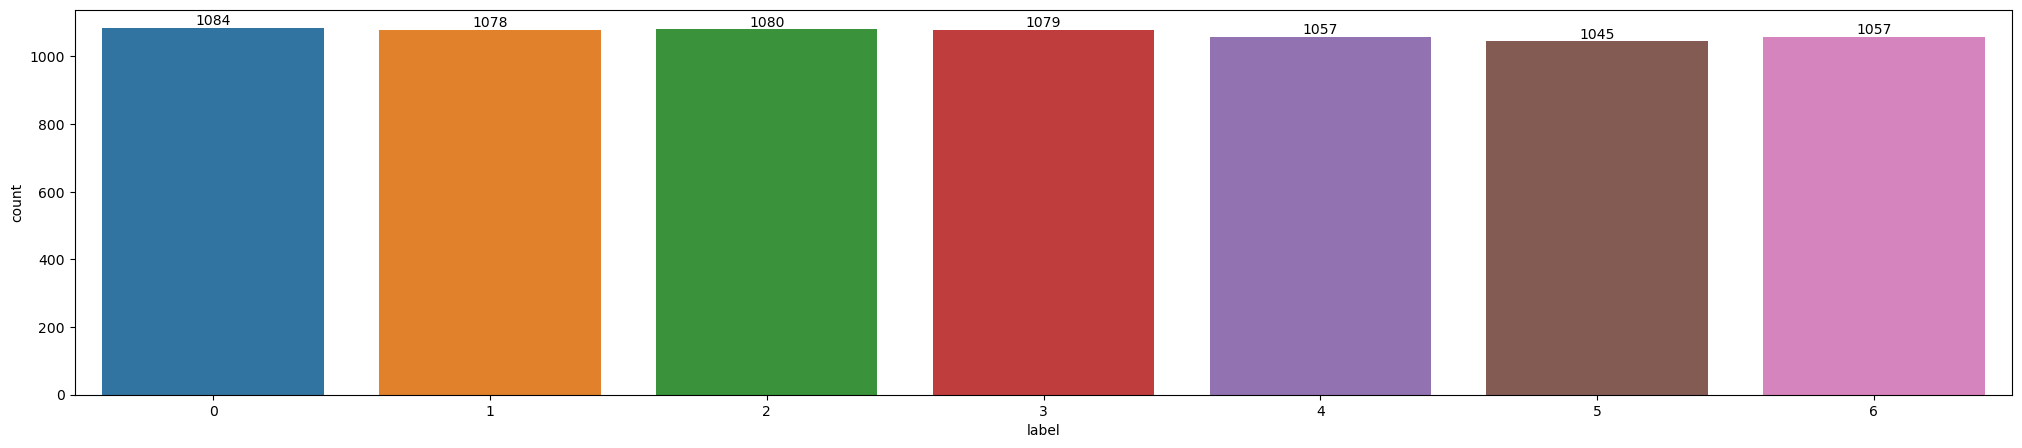

In [9]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, x = data['label'])
ax.bar_label(ax.containers[0])

### 3.2. Processing Columns

In [5]:
stopword_en = pd.read_csv('../../en_stopword_1555.txt', header=None).drop_duplicates()
en_stopword = stopword_en[0].values.tolist()
en_stopword = [word.strip() for word in en_stopword]

nltk_stopword = stopwords.words('english')

combined_stopwords = pd.DataFrame(en_stopword + nltk_stopword).drop_duplicates()
stopword_list = combined_stopwords[0].values.tolist()

def lower_text(text):
    return text.lower()

def alphanumeric_text(text):
    # return re.sub("[^a-z0-9\s]","", text)
    text = text.lower()
    return re.sub(r'[^\w\s.,]', '', text)

def remove_duplicate_words(text):
    return re.sub(r'\b(\w+)(\s+\1)+\b', r'\1', text)

def clean(text):
    text = str(text).lower()
    text = re.sub(r'\brt\b', '', text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r'[^\w\s.,]', '', text)
    text = [word for word in text.split(' ') if word not in nltk_stopword]
    return " ".join(text)
lemmatizer = WordNetLemmatizer()

def lemmatize_word(word):
    return lemmatizer.lemmatize(word, pos='v')

def lemmatize_sentence(sentence):
    words = nltk.word_tokenize(sentence) 
    words = [word for word in words if word.isalnum()] 
    words = [lemmatize_word(word) for word in words]  
    return ' '.join(words)  

In [6]:
data['clean_text'] = data['text'] \
                    .progress_apply(clean) \
                    .progress_apply(lemmatize_sentence) \
                    # .progress_apply(lower_text) \
                    # .progress_apply(remove_duplicate_words) \
                    # .progress_apply(alphanumeric_text) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if word not in (nltk_stopword)])) \
                    # .progress_apply(lambda x: ' '.join([word for word in x.split(' ') if len(word) >= 4])) \
                    # .progress_apply(lemmatizer) \
data.head()

  0%|          | 0/7480 [00:00<?, ?it/s]

  0%|          | 0/7480 [00:00<?, ?it/s]

,biner_label,text,label,clean_text
0,1000000,"During the period of falling in love, each tim...",0,period fall love time meet especially meet lon...
1,100000,When I was involved in a traffic accident.,1,involve traffic accident
2,10000,When I was driving home after several days of...,2,drive home several days hard work motorist ahe...
3,1000,When I lost the person who meant the most to me.,3,lose person mean
4,100,The time I knocked a deer down - the sight of ...,4,time knock deer sight animals injuries helples...


<Axes: xlabel='text_len'>

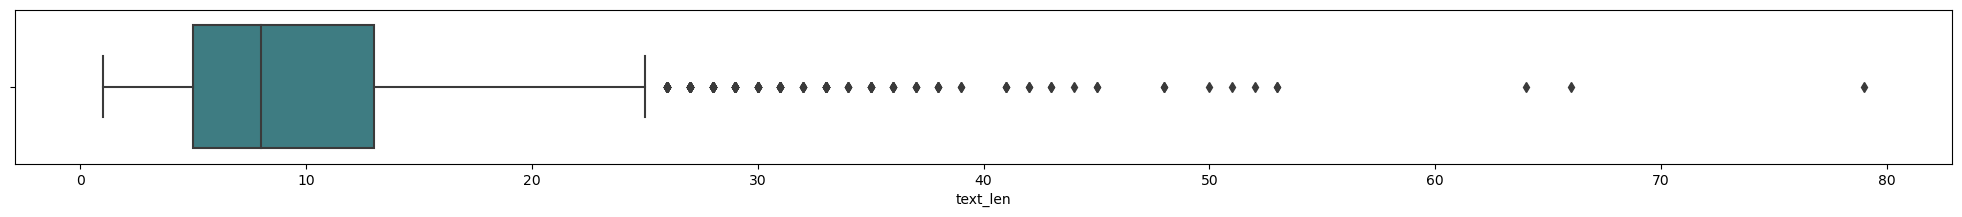

In [7]:
text_len = [len(word) for word in data['clean_text'].str.split(' ')]
data['text_len'] = pd.DataFrame(text_len)

fig, ax = plt.subplots(figsize=(25, 2))
sns.boxplot(x=data['text_len'], palette="crest")

In [15]:
len(data[data['text_len'] > 13])

1691

In [13]:
print(data['text_len'].quantile(.25))
print(data['text_len'].quantile(.75))

5.0
13.0


<Axes: xlabel='text_len'>

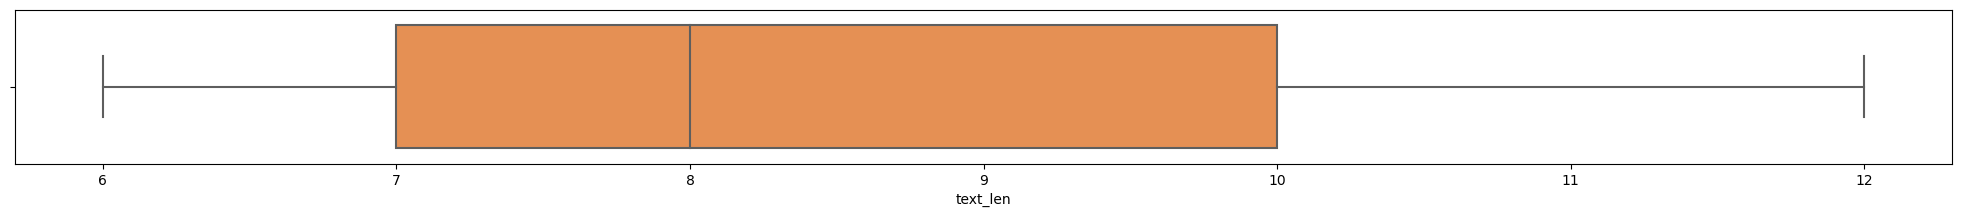

In [16]:
Q1 = data['text_len'].quantile(.25)
Q3 = data['text_len'].quantile(.75)

data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

fig, axes = plt.subplots(figsize=(25, 2))
sns.boxplot(x = data['text_len'], palette="Oranges")

[Text(0, 0, '1084'),
 Text(0, 0, '1078'),
 Text(0, 0, '1080'),
 Text(0, 0, '1079'),
 Text(0, 0, '1057'),
 Text(0, 0, '1045'),
 Text(0, 0, '1057')]

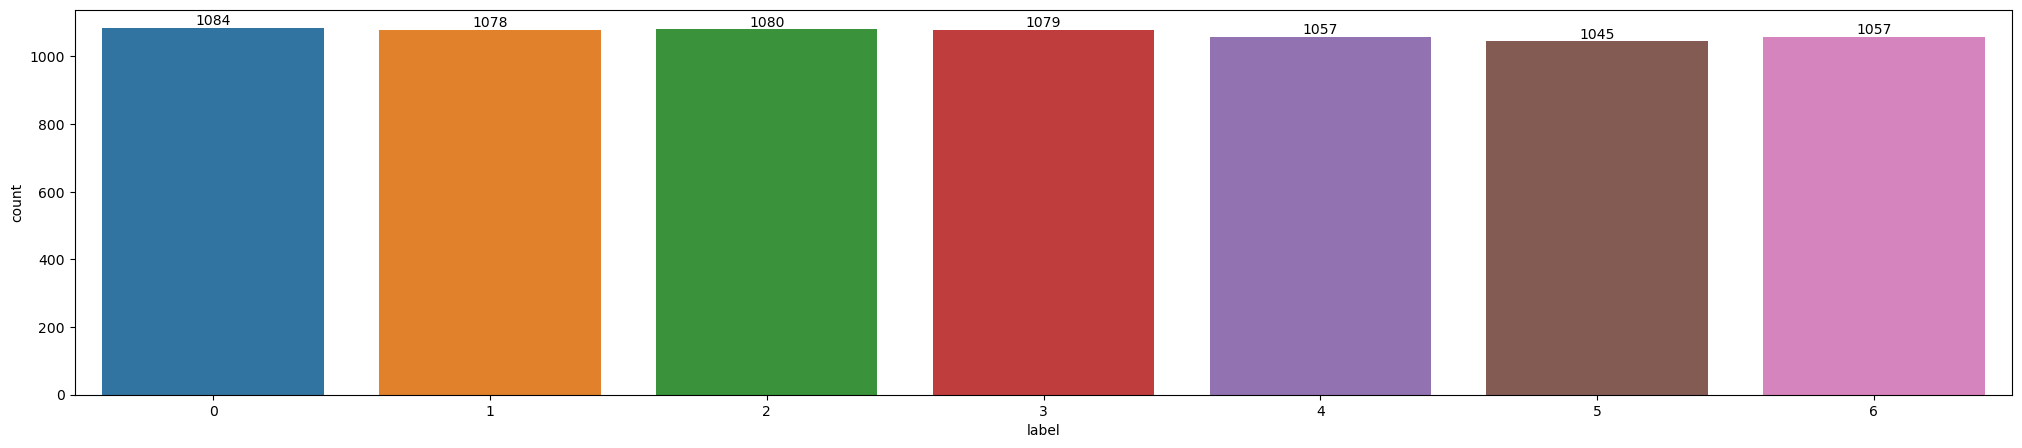

In [10]:
plt.subplots(figsize = (25,5))
ax = sns.countplot(data, x = data['label'])
ax.bar_label(ax.containers[0])

# 4. Preparing Dataset

In [8]:
LE = LabelEncoder()

X = data['clean_text']
# Y = LE.fit_transform(data['label']) ### For Classification Algoritms
# Y = pd.get_dummies(data['label']) ### For Deep Learning Algoritms
Y = data['label'] ### For Deep Learning Algoritms

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(5250,)
(1482,)
(748,)


In [9]:
vocab_size = 7207
embedding_dim = 256
max_length = 80
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [10]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

7206


In [29]:
# Tokenizing 
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X)

print(len(tokenizer.word_index))

# Text to Sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
testing_sequences = tokenizer.texts_to_sequences(X_test)
validating_sequences = tokenizer.texts_to_sequences(X_val)

# Add padding
training_padded = pad_sequences(training_sequences, maxlen = max_length, padding = padding_type)
testing_padded = pad_sequences(testing_sequences, maxlen = max_length, padding = padding_type)
validating_padded = pad_sequences(validating_sequences, maxlen = max_length, padding = padding_type)

# Convert to numpy array
training_padded = np.array(training_padded)
training_label = np.array(y_train)

testing_padded = np.array(testing_padded)
testing_label = np.array(y_test)

validating_padded = np.array(validating_padded)
validating_label = np.array(y_val)

# Undersampling
rus = RandomUnderSampler(random_state=42, replacement=True)# fit predictor and target variable

training_padded, training_label = rus.fit_resample(training_padded, training_label)
testing_padded, testing_label = rus.fit_resample(testing_padded, testing_label)
validating_padded, validating_label = rus.fit_resample(validating_padded, validating_label)

print(training_padded.shape)
print(testing_padded.shape)
print(validating_padded.shape)


66669
(2652, 570)
(738, 570)
(402, 570)


# 5. Deep Learning Model

In [26]:
def DNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Flatten())

    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(5, activation='softmax'))
    return model


def CNN_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Conv1D(64, 3, kernel_regularizer=keras.regularizers.l2(l=0.001)))
    model.add(BatchNormalization())
    model.add(ReLU())
    model.add(MaxPooling1D())

    model.add(Flatten())
    # model.add(Dense(4098, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    # model.add(Dense(256, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    return model

def LSTM_Model():
    model = Sequential()
    model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
    model.add(Bidirectional(LSTM(256, return_sequences=True)))
    model.add(Bidirectional(LSTM(256)))
    model.add(Dense(2, activation='softmax'))
    return model

def GRU_Model():
    model = Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    # model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True)))
    model.add(Bidirectional(GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    model.add(Dense(7, activation='softmax'))
    return model

# model = DNN_Model()
# model = CNN_Model()
# model = LSTM_Model()
model = GRU_Model()

model.summary()

opt = Adam(learning_rate = 0.000_01)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 13, 256)           1844992   
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              296448    
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 2,143,239
Trainable params: 2,143,239
Non-trainable params: 0
_________________________________________________________________


In [27]:
num_epoch = 50
batch_size = 24
history = model.fit(training_padded, training_label, 
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (validating_padded, validating_label))

Epoch 1/50
101/101 [==============================] - 3s 13ms/step - loss: 1.9473 - accuracy: 0.1255 - val_loss: 1.9459 - val_accuracy: 0.1445
Epoch 2/50
101/101 [==============================] - 1s 8ms/step - loss: 1.9456 - accuracy: 0.1453 - val_loss: 1.9449 - val_accuracy: 0.1763
Epoch 3/50
101/101 [==============================] - 1s 8ms/step - loss: 1.9439 - accuracy: 0.1672 - val_loss: 1.9439 - val_accuracy: 0.1676
Epoch 4/50
101/101 [==============================] - 1s 8ms/step - loss: 1.9423 - accuracy: 0.1945 - val_loss: 1.9431 - val_accuracy: 0.1647
Epoch 5/50
101/101 [==============================] - 1s 8ms/step - loss: 1.9407 - accuracy: 0.2188 - val_loss: 1.9423 - val_accuracy: 0.1647
Epoch 6/50
101/101 [==============================] - 1s 8ms/step - loss: 1.9392 - accuracy: 0.2300 - val_loss: 1.9413 - val_accuracy: 0.1821
Epoch 7/50
101/101 [==============================] - 1s 8ms/step - loss: 1.9376 - accuracy: 0.2411 - val_loss: 1.9404 - val_accuracy: 0.1705
Epoch

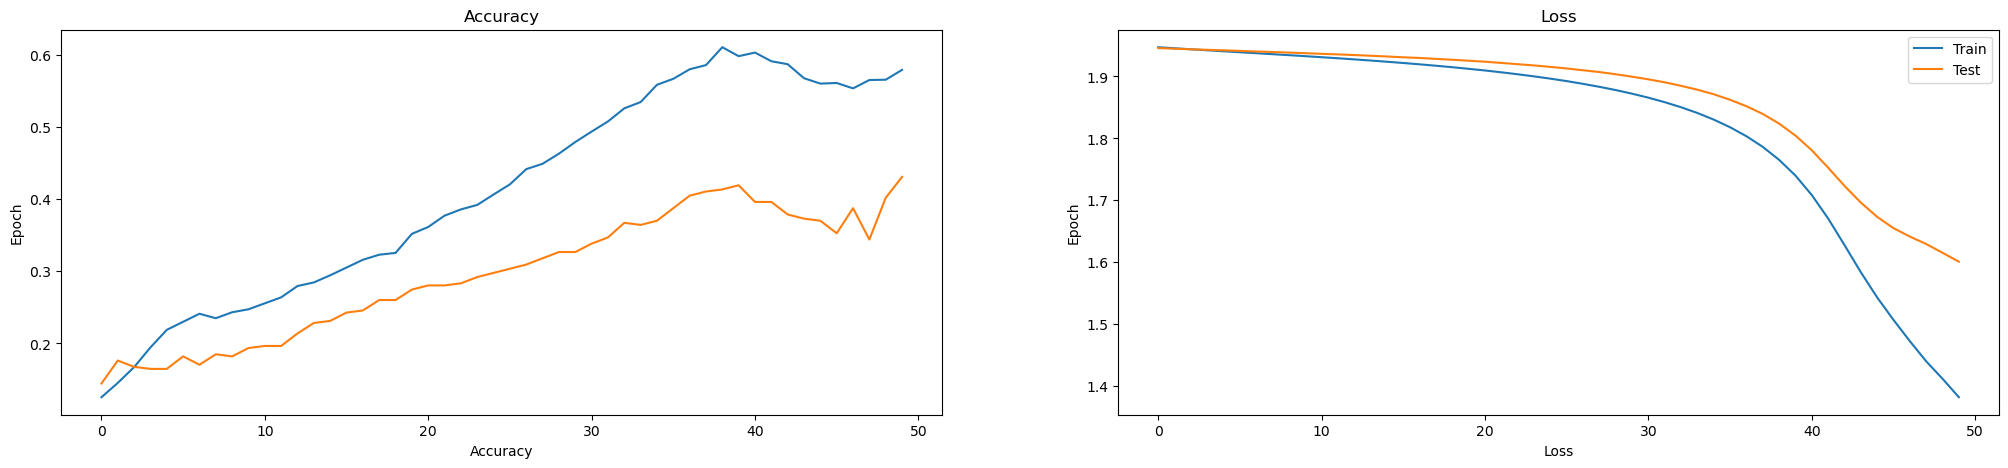

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(25, 5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Accuracy')
ax[0].set_ylabel('Epoch')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss')
ax[1].set_xlabel('Loss')
ax[1].set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [77]:
train_predictions = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label.argmax(axis=1)})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print(train_results['Diff'].sum(), '/', len(train_results['Diff']))

   Train Predictions  Actuals  Diff
0                  2        2     0
1                  6        2     4
2                  4        4     0
3                  6        2     4
4                  1        1     0
2061 / 1482


In [78]:
y_pred = model.predict(testing_padded, verbose=0).argmax(axis=1)
print(classification_report(testing_label.argmax(axis=1),y_pred))

              precision    recall  f1-score   support

           0       0.64      0.59      0.61       224
           1       0.60      0.64      0.62       204
           2       0.36      0.35      0.36       212
           3       0.55      0.56      0.56       217
           4       0.60      0.52      0.56       208
           5       0.40      0.39      0.39       194
           6       0.41      0.48      0.44       223

    accuracy                           0.51      1482
   macro avg       0.51      0.51      0.51      1482
weighted avg       0.51      0.51      0.51      1482



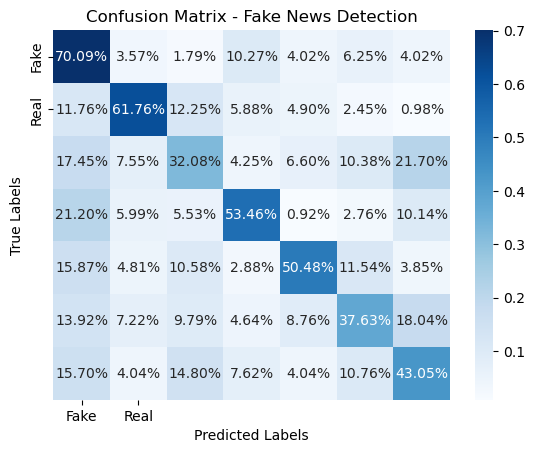

In [79]:
labels = ['Fake','Real']

y_pred = np.rint(model.predict(testing_padded, verbose=0)).argmax(axis=1).flatten()
con_mat = confusion_matrix(testing_label.argmax(axis=1),y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
# sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()

# 6. Classification Algoritms

In [20]:
adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
bagging = BaggingClassifier(n_jobs=-1)
extraTrees = ExtraTreesClassifier(max_depth=100, n_jobs=-1, random_state=42)
gradient = GradientBoostingClassifier(max_depth=100, n_estimators=100, learning_rate=.01,  random_state=42)
randomForest = RandomForestClassifier(max_depth=100, random_state=42, n_jobs=-1)
histGradientBoosting = HistGradientBoostingClassifier()
XGB = XGBClassifier(n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)
decisionTree = DecisionTreeClassifier(random_state=42, max_depth=100)
linear = LinearRegression()
pac = PassiveAggressiveClassifier(random_state=42)

model = StackingClassifier([
    ('XGB', XGB),
    ('randomforest', randomForest),
    ('histGradientBoosting', histGradientBoosting),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('extraTres', extraTrees),
    ('knn', knn),
    ('decisionTree', decisionTree),
    # ('pac', pac),
    # ('linear', linear),
    # ('gradient', gradient),

], n_jobs=-1)

In [21]:
model.fit(training_padded, training_label)

c:\Users\indiz\miniconda3\envs\gan\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


StackingClassifier(estimators=[('XGB',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              gpu_id=None, grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning_...
                               ('histGradientBoosting',
                                HistGradientBoostingClassifier()),
                               ('adaboost',
                                AdaBoostClassifier(n_estimators=100,
                                                   random_state=42)),
                               ('bagging', BaggingClassifier(n_jobs=-1)),
                               ('extraTres',
                                ExtraTreesClassifier(max_depth=100, n_jobs=-1,
                                                     random_state=42)),
                               ('knn', KNeighborsClassifier(n_jobs=-1)),
                               ('decisionTree',
                                DecisionTreeClassifier(max_depth=100,
                                                       random_state=42))],
                   n_jobs=-1)

In [23]:
print("Train Score        :",round((model.score(training_padded, training_label)*100), 2),'%')
print("Test Score         :",round((model.score(testing_padded, testing_label)*100), 2),'%')

y_pred = model.predict(testing_padded)

print("R Squared Error    :",round(r2_score(testing_label, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(testing_label, y_pred), 2))

Train Score        : 94.59 %
Test Score         : 30.5 %
R Squared Error    : -0.56
Mean Squared Error : 6.34


In [27]:
train_predictions = model.predict(testing_padded).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':testing_label})
# train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
train_results['Diff'] = train_results['Actuals'] == train_results['Train Predictions']
print(train_results.head(5))
# print(train_results['Diff'].sum(), '/', len(train_results['Diff']))
train_results['Diff'].value_counts()

   Train Predictions  Actuals   Diff
0                  5        2  False
1                  5        2  False
2                  4        4   True
3                  1        2  False
4                  1        1   True


False    1030
True      452
Name: Diff, dtype: int64

In [28]:
y_pred = model.predict(testing_padded)
print(classification_report(y_pred,testing_label))

              precision    recall  f1-score   support

           0       0.34      0.43      0.38       179
           1       0.35      0.28      0.32       253
           2       0.19      0.20      0.20       202
           3       0.40      0.39      0.39       222
           4       0.38      0.36      0.37       223
           5       0.22      0.22      0.22       195
           6       0.24      0.25      0.25       208

    accuracy                           0.30      1482
   macro avg       0.30      0.31      0.30      1482
weighted avg       0.31      0.30      0.31      1482



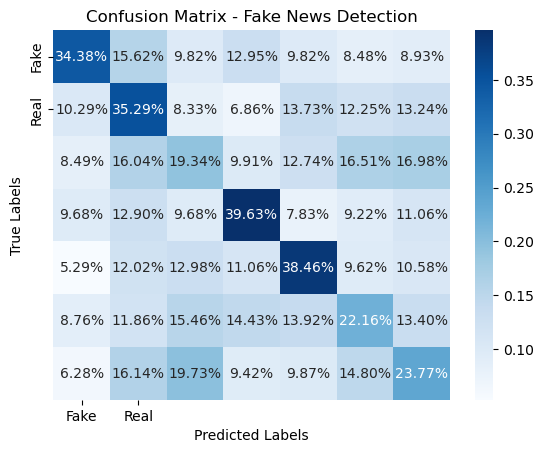

In [29]:
labels = ['Fake','Real']

y_pred = np.rint(model.predict(testing_padded))
con_mat = confusion_matrix(testing_label,y_pred)

cm_percent = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]

sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Fake News Detection')
plt.show()